In [1]:
import os
import glob
import pydicom
import nibabel as nib
import pandas as pd
import numpy as np
from pydicom.pixel_data_handlers.util import apply_voi_lut
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

from utils.dcm_utils import rescale_img_to_hu

In [2]:
patient_id = "1.2.826.0.1.3680043.8693"

In [4]:
# DATA_DIR = "../../dataset/"
DATA_DIR = "/Volumes/SSD970/"
TRAIN_DIR = os.path.join(DATA_DIR, "train_images")
SEGM_DIR = os.path.join(DATA_DIR, "segmentations")

train_df = pd.read_csv(os.path.join(DATA_DIR, "train_df_with_slices.csv"))
print(train_df.shape)
train_df.head()

(2019, 10)


,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7,num_slices
0,1.2.826.0.1.3680043.6200,1,1,1,0,0,0,0,0,243
1,1.2.826.0.1.3680043.27262,1,0,1,0,0,0,0,0,406
2,1.2.826.0.1.3680043.21561,1,0,1,0,0,0,0,0,385
3,1.2.826.0.1.3680043.12351,0,0,0,0,0,0,0,0,501
4,1.2.826.0.1.3680043.1363,1,0,0,0,0,1,0,0,199


In [5]:
dcm = pydicom.dcmread(os.path.join(TRAIN_DIR, f"{patient_id}/1.dcm"))
dcm

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.8693.1.1
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.8693.1.1
(0008, 0023) Content Date                        DA: '20220727'
(0008, 0033) Content Time                        TM: '180708.115861'
(0010, 0010) Patient's Name                      PN: '8693'
(0010, 0020) Patient ID                          LO: '8693'
(0018, 0050) Slice Thickness                     DS: '0.488281'
(0020, 000d) Study Instance UID                  UI: 1.2.826.0.1.

In [6]:
def read_patient_dcm(patient_id):
    # copy from others, do not use
    num_slices = train_df.loc[train_df["StudyInstanceUID"] == patient_id, "num_slices"].values[0]
    print(f"Number of slices for patient: {num_slices}")
    print(f"Fracture information for patient: ")
    print(f"{train_df[train_df['StudyInstanceUID'] == patient_id].iloc[:, 1:-1]}")
    patient_dir = os.path.join(TRAIN_DIR, patient_id)

    for i in range(num_slices):
        # dicom filenames start from 1
        ds = pydicom.dcmread(os.path.join(patient_dir, f"{i+1}.dcm"))
        if i == 0:
            pixel_spacing = ds.PixelSpacing
            slice_thickness = ds.SliceThickness
            axial_aspect = pixel_spacing[1] / pixel_spacing[0]
            sagittal_aspect = pixel_spacing[1] / slice_thickness
            coronal_aspect = slice_thickness / pixel_spacing[0]
            img_shape = list(ds.pixel_array.shape)
            img_shape.append(num_slices)
            img3d = np.zeros(img_shape)
        img2d = rescale_img_to_hu(ds)
        img3d[:, :, i] = img2d

    return img3d, axial_aspect, sagittal_aspect, coronal_aspect


In [7]:
patient_dcm, aa, sa, ca = read_patient_dcm(patient_id)

Number of slices for patient: 69
Fracture information for patient: 
     patient_overall  C1  C2  C3  C4  C5  C6  C7
246                1   0   0   0   0   0   1   0


보다싶이 이게 문제는 그냥 하나하나 보여주면 안된다는것
sagittal_aspect 계산이 틀렸다.

In [8]:
sa

1.0

맞다 이러니까 정확하게 나왔다.
image position 의 차이를 aspect 에다가 넣어야 한다.

Text(0.5, 1.0, 'Sagittal')

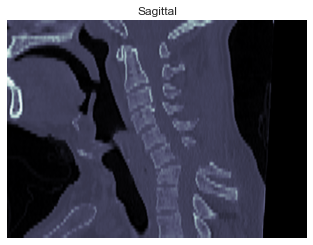

In [9]:
sagittal_pos = 244
sa = 2.63 / 0.4882  # z_distance / pixel_spacing
fig, ax = plt.subplots(1, 1)
ax.imshow(np.flip(np.rot90(patient_dcm[:, sagittal_pos, :], k=3), axis=1), cmap="bone")
ax.set_aspect(sa)
ax.axis("off")
ax.set_title("Sagittal")